# Машинное обучение – весна 2024

# Домашнее задание 2: Логистическая регрессия, метод опорных векторов, работа с текстами

Правила:

- Домашнее задание оценивается в 10 баллов.

- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

- Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

- Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

# Задание 1: LR, SVM и калибровка вероятностей (2 балла + 0.5 бонус)

In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [546]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [547]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: **потому что возвращаются вероятности отнесения к классу 1, а не метка класса** 

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [548]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


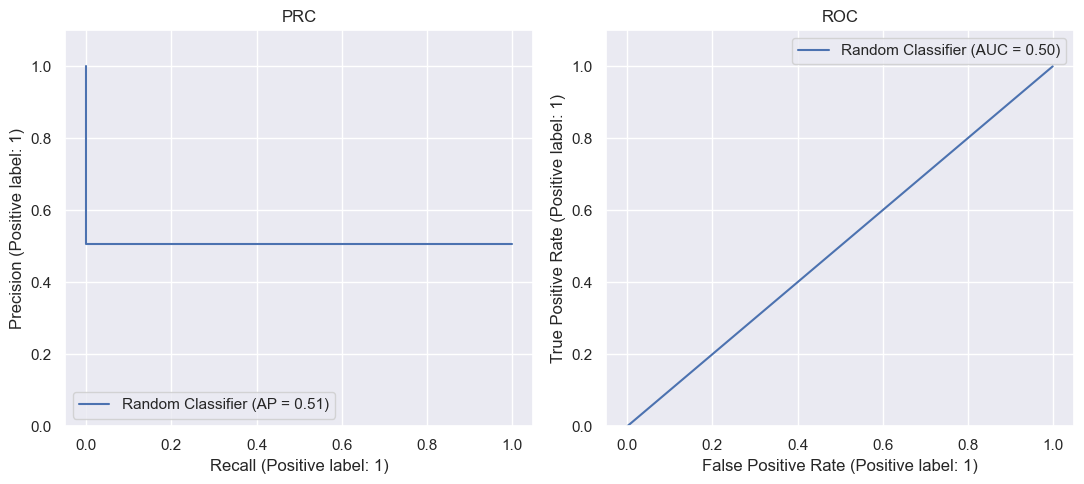

In [549]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  print('AUC-PR: %.5f' % auc(recall, precision))
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)

  RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)

  plt.tight_layout()
  plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [550]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`).

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).



In [551]:
#your code here
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) # иначе было очень навязчиво про The default value of `dual` will change from `True` to `'auto'` in 1.5. 

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

lsvc = LinearSVC(max_iter=1000, random_state=42)
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(lsvc, param_grid, cv=5, scoring = 'average_precision') # По ссылке сказано, что AUC-PR и average precision одинаковы
# https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap

# Обучаем на обучающей выборке
grid_search.fit(X_train, y_train)

# Выводим лучшее значение параметра C и соответствующее значение AUC-PR
print("Лучшее значение C:", grid_search.best_params_)
print("Лучшее значение AUC-PR:", grid_search.best_score_)




/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: Convergenc

Лучшее значение C: {'C': 0.01}
Лучшее значение AUC-PR: 0.8233608725396276


/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**К несчастью, у меня так и не сошлись опорные вектора. Я пробовал увеличивать количество итераций до 1000000, но от этого сходимость не появилась, а скорость работы сильно замедлилась. Так что работаем с несошедшимися оценками** 

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков

SVM при C = 1 metrics
AUC-PR: 0.83189
AUC-ROC: 0.77234


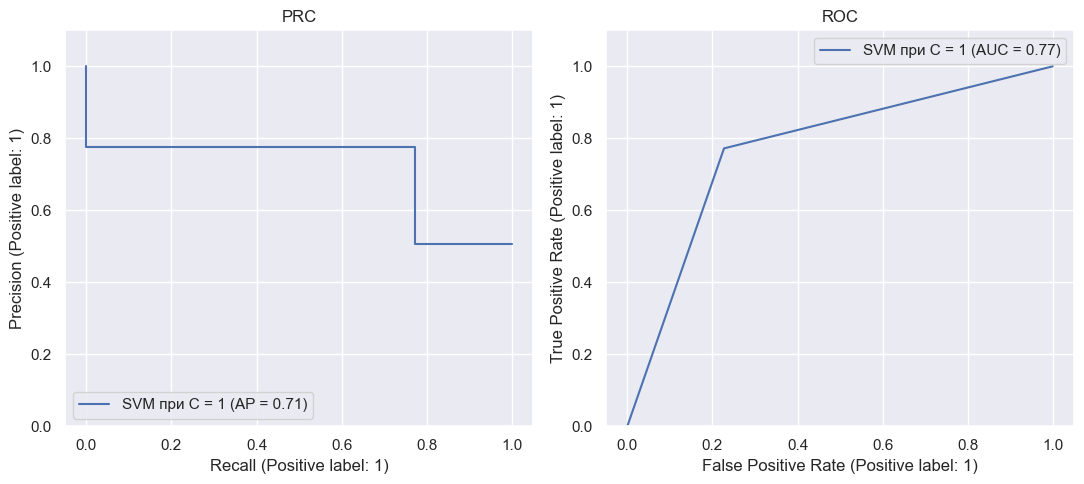

In [552]:
#your code here
y_pred_lsvm = grid_search.predict(X_test)
depict_pr_roc(y_test, y_pred_lsvm, 'SVM при C = 1')

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [553]:
# Обе метрики выросли по сравнению со случайным классификатором, так что мы можем сказать, что метод работает лучше, чем случайный классификатор 

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [554]:
#your code here
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000, random_state=42)

param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring = 'average_precision') # По ссылке сказано, что AUC-PR и average precision одинаковы
# https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap

grid_search.fit(X_train, y_train)

print("Лучшее значение C:", grid_search.best_params_)
print("Лучшее значение AUC-PR:", grid_search.best_score_)

Лучшее значение C: {'C': 0.001}
Лучшее значение AUC-PR: 0.8277305684152289


LogReg with C = 0.001 metrics
AUC-PR: 0.82858
AUC-ROC: 0.76773


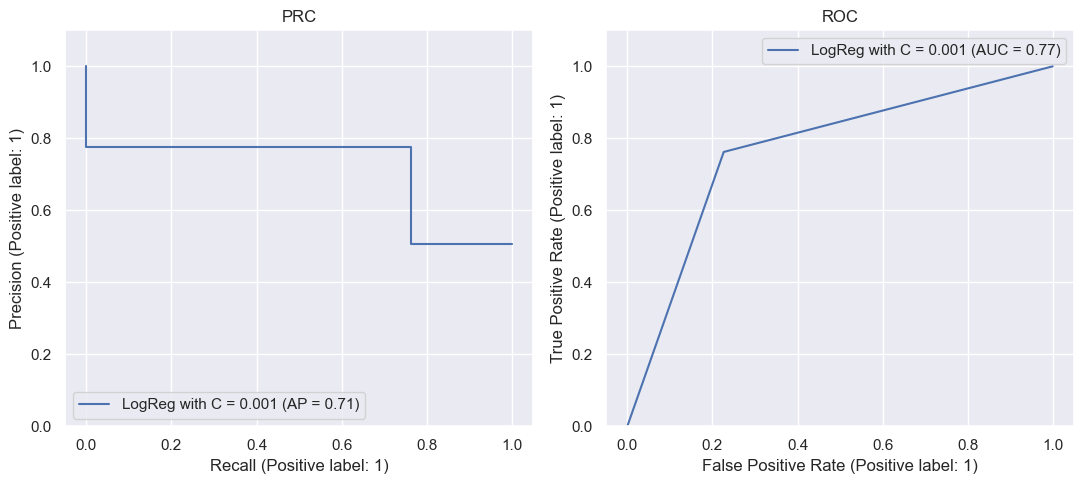

In [555]:
y_pred_lr = grid_search.predict(X_test)
depict_pr_roc(y_test, y_pred_lr, 'LogReg with C = 0.001')
# обе метрики выросли по сравнению со случайным классификатором и почти совпадают с метриками для LSVM

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000
LogReg metrics
AUC-PR: 0.82858
AUC-ROC: 0.76773
LSVM metrics
AUC-PR: 0.83189
AUC-ROC: 0.77234


/var/folders/c2/pn863xcd52n1281sl8gmr97m0000gn/T/ipykernel_58611/2933229378.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/c2/pn863xcd52n1281sl8gmr97m0000gn/T/ipykernel_58611/2933229378.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


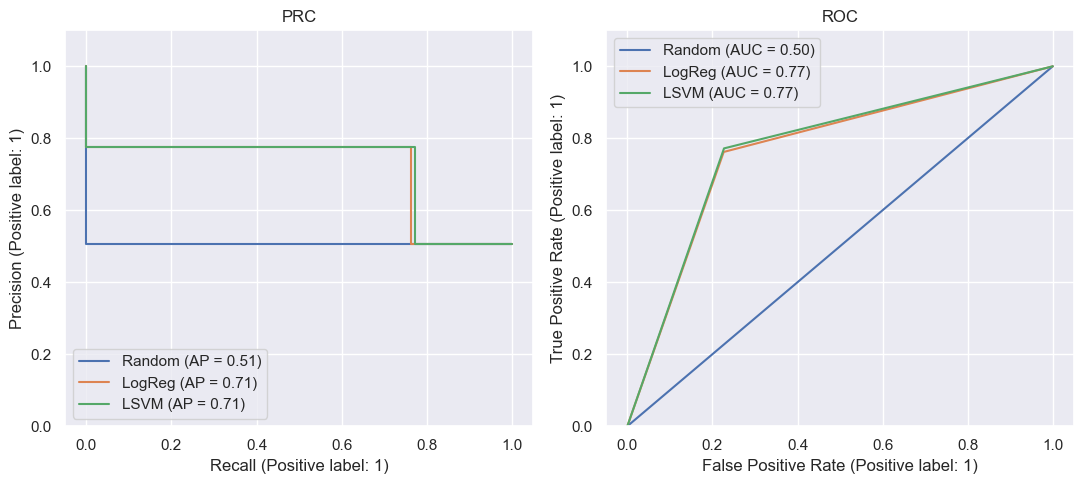

In [556]:
#your code here
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
depict_pr_roc(y_test, y_random, 'Random', ax)
depict_pr_roc(y_test, y_pred_lr, 'LogReg', ax)
depict_pr_roc(y_test, y_pred_lsvm, 'LSVM', ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** отличий почти нет. SVM дает чуть более высокие метрики качества, но есть вероятность, что при небольшом переборе гиперпараметров логит догонит SVM 

#### __Задание 1.2 Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. В этот раз воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах, а в `LinearSVC` нет. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы (атрибут `support_vectors_`).

In [557]:

from sklearn.svm import SVC

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)

model = SVC(kernel='linear')
model.fit(X, y)



SVC(kernel='linear')

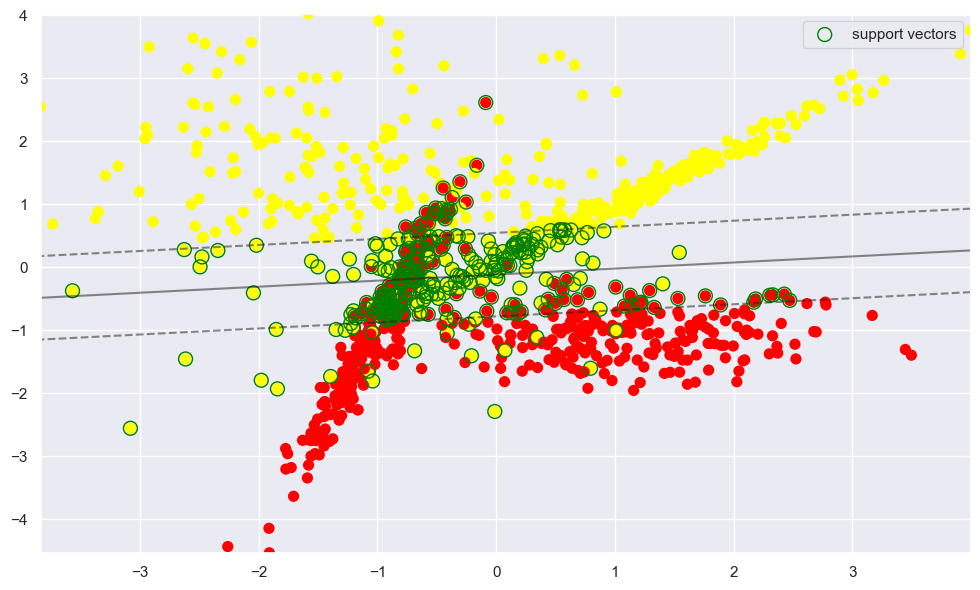

In [558]:
def plot_svm_2D(X, y, model,  plot_support=True):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape) 

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

    #Отрисовали опорные векторы
    if plot_support:
        sv = model.support_vectors_
        plt.scatter(sv[:, 0], sv[:, 1],
                   label='support vectors',
                   s=100,
                   linewidth=1,
                   edgecolor="green",
                   facecolors='none')

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** которые находятся близко к разделяющей плоскости или на ней

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

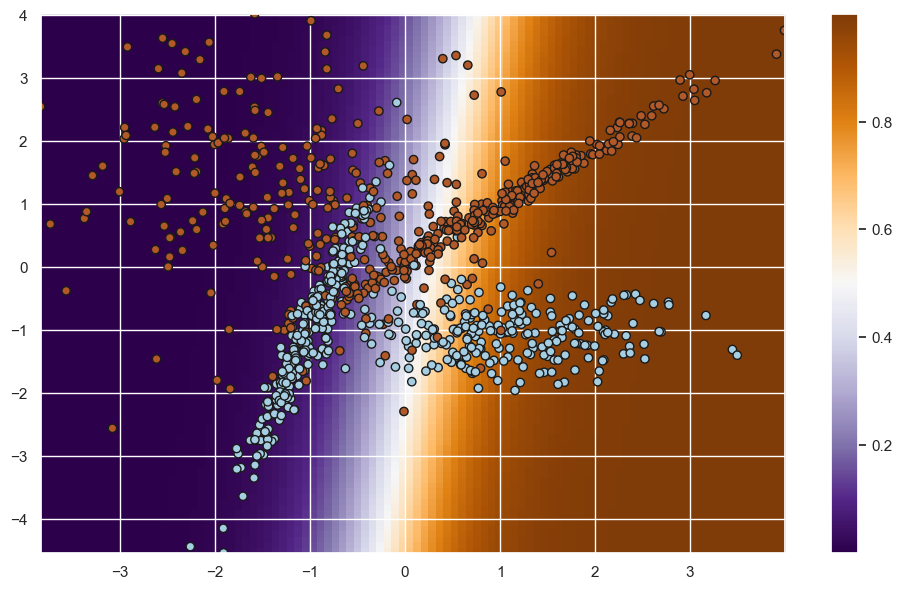

In [559]:
def plot_logreg_2D(X, y, model):
    # Создаем сетку для визуализации
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Получаем вероятности для каждой точки сетки
    Z = model.predict_proba(xy)[:, 1]  # Вероятности класса 1
    Z = Z.reshape(XX.shape)

    # Визуализируем распределение вероятностей
    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    # Отрисовываем выборку
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

    plt.colorbar(image)

model = LogisticRegression(random_state = 42)
model.fit(X, y)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** на картинке это белая прямая линия, разделяющая плоскость. Это прямая, так как 

$$
p(y=+1|x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_n x_n)}}
$$

Подставив 0.5 и вспомнив, что у нас всего два признака:

$$
\frac{1}{2} = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2)}}
$$

$$
e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2)} = 1
$$

$$
-(\beta_0 + \beta_1 x_1 + \beta_2 x_2) = 0
$$

что является, очевидно, уравнением прямой 


#### __Задание 1.3 Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [560]:
def plot_calibration_curve(y_test, preds, name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) # иначе же не середина выходит......
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) # зачем нам минимальное количество, нужно же среднее.....
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios, label = name)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

**Внимание:** для получения вероятностей из метода опорных векторов требуется использовать формулу:

$$probas = \frac{preds - min(preds)}{max(preds) - min(preds)}$$

где $preds$ - результат работы метода decision_function

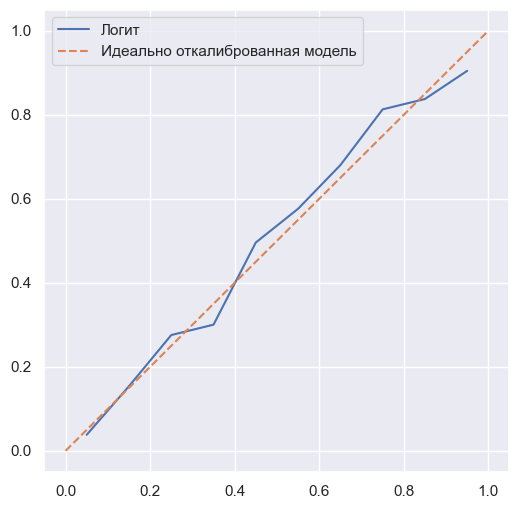

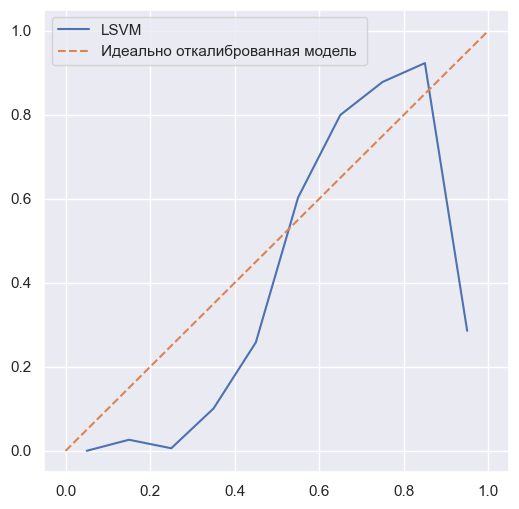

In [561]:
X, y = make_classification(n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr= LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
svm = SVC(kernel = 'linear', probability=False, random_state=42)
svm.fit(X_train, y_train)
preds_log_reg = lr.predict_proba(X_test)[:, 1]
preds_svm = svm.decision_function(X_test)
preds_svm_probas = (preds_svm - preds_svm.min()) / (preds_svm.max() - preds_svm.min())

plot_calibration_curve(y_test, preds_log_reg, 'Логит')
plt.plot([0, 1], [0, 1], '--', label='Идеально откалиброванная модель')
plt.grid()
plt.legend()
plot_calibration_curve(y_test, preds_svm_probas, 'LSVM')
plt.plot([0, 1], [0, 1], '--', label='Идеально откалиброванная модель ')
plt.grid()
plt.legend()




**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии?

**Ответ:** **модель для логита откалибрована очень хорошо: предсказанные вероятности лежат очень близко к идеально откалиброванному классификатору. Модель  для SVM откалибрована плохо: она сильно не уверена до примерно 0.5, чрезмерно уверена до примерно 0.8, недостаточно уверена после.**

Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`).

(array([374., 310., 279., 283., 245., 271., 242., 292., 356., 348.]),
 array([0.00219807, 0.10166041, 0.20112276, 0.30058511, 0.40004745,
        0.4995098 , 0.59897215, 0.69843449, 0.79789684, 0.89735919,
        0.99682153]),
 <BarContainer object of 10 artists>)

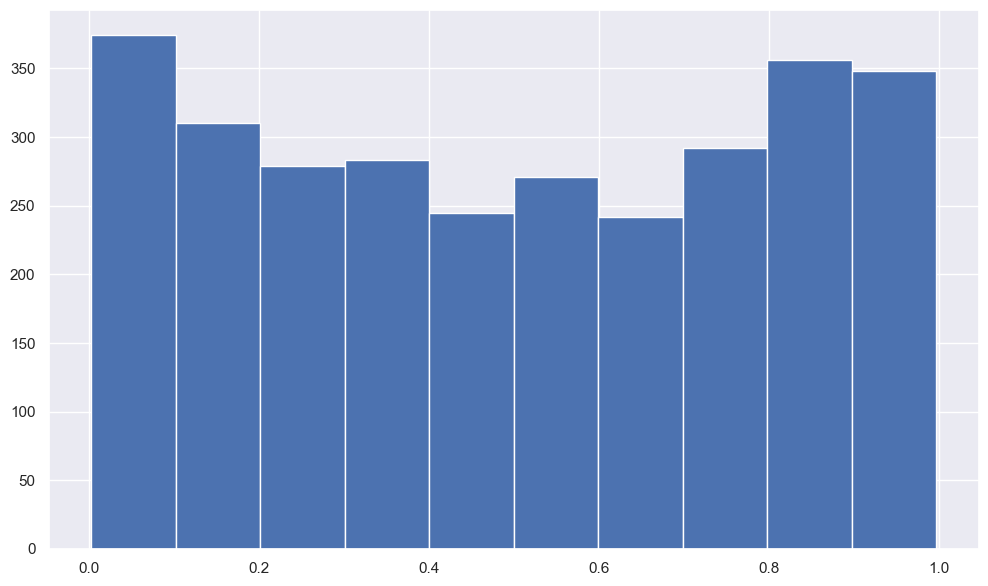

In [562]:
#your code here
plt.hist(preds_log_reg)

(array([  8.,  38., 165., 387., 624., 718., 624., 337.,  91.,   8.]),
 array([-5.13253612, -4.16909916, -3.20566219, -2.24222523, -1.27878827,
        -0.3153513 ,  0.64808566,  1.61152263,  2.57495959,  3.53839656,
         4.50183352]),
 <BarContainer object of 10 artists>)

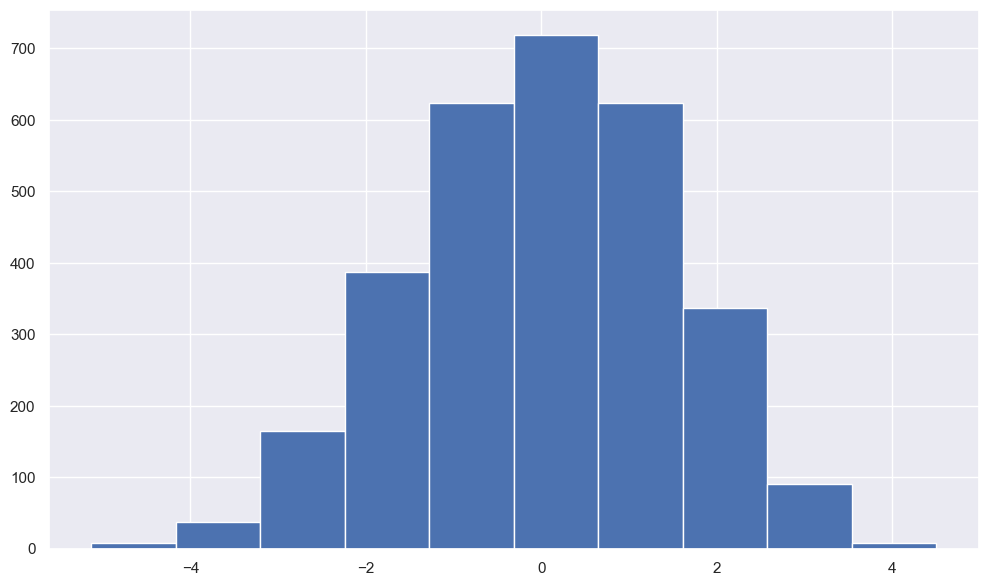

In [563]:
plt.hist(preds_svm)

(array([  8.,  38., 165., 387., 624., 718., 624., 337.,  91.,   8.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

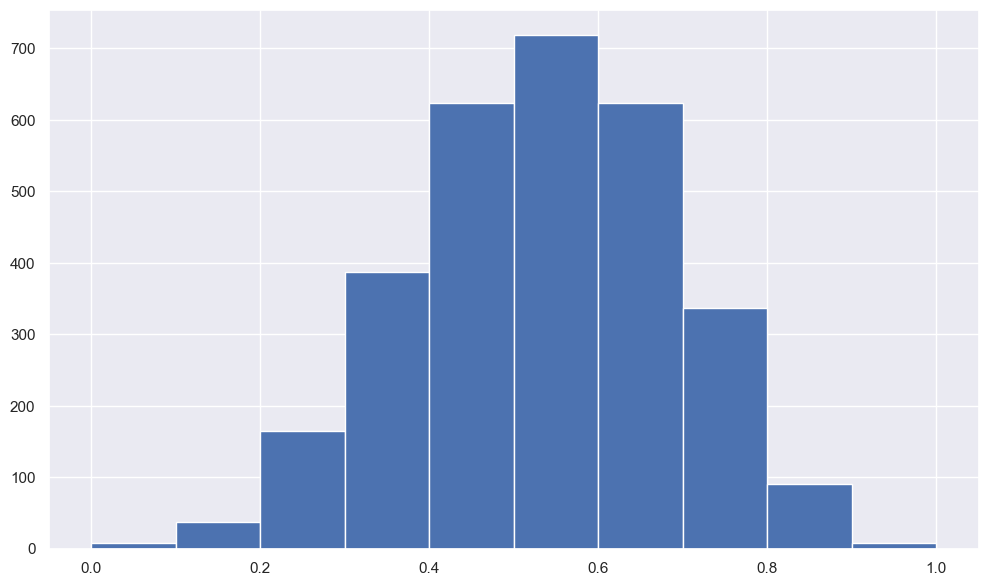

In [564]:
plt.hist(preds_svm_probas)

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** распределение предсказаний SVM близко к колоколообразному, распределение предсказаний у логита близко к U-образному или равномерному. Форма логита объясняется тем, что логит использует для предсказания сигмоиду, которая возвращает вероятности; в связи с синтетическим и достаточно равномерным характером входных данных логит вернул достаточно равномерный аутпут. SVM использует разделение гиперплоскостью с максимальным расстоянием между классами, поэтому SVM склонен к большей равномерности аутпута. 

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

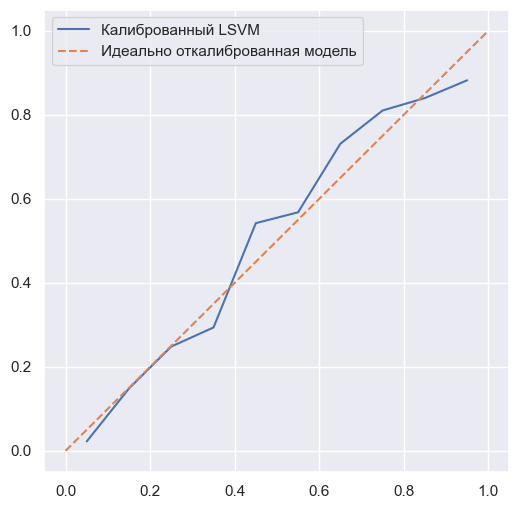

In [565]:
#your code here
from sklearn.calibration import CalibratedClassifierCV
svm = SVC(kernel = 'linear', probability=False, random_state=42)
svm.fit(X_train, y_train)
calibrated_svm = CalibratedClassifierCV(base_estimator=svm, method='sigmoid')
calibrated_svm.fit(X_train, y_train)
preds_csvm = calibrated_svm.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds_csvm, 'Калиброванный LSVM')
plt.plot([0, 1], [0, 1], '--', label='Идеально откалиброванная модель')
plt.grid()
plt.legend()

**Вопрос:** Улучшилась ли калибровочная кривая?

**Ответ:** да, конечно. Калибровочная кривая стала гораздо ближе к идеально откалиброванному классификатору

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

Используем регрессию Платта, которая сразу будет возвращать предсказанные вероятности:

In [566]:
def platt_calibration(pred_probas, y_test):
    lr = LogisticRegression(C=1e5, solver="lbfgs")
    lr.fit(pred_probas.reshape(-1, 1), y_test)
    rets = lr.predict_proba(pred_probas.reshape(-1, 1))[:, 1]
    return rets 

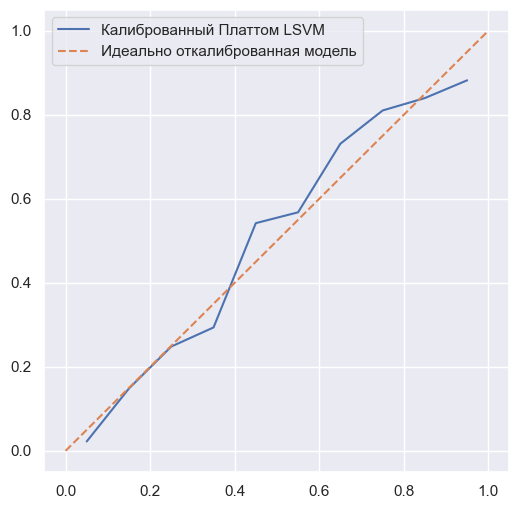

In [567]:
svm = SVC(kernel = 'linear', probability=False, random_state=42)
svm.fit(X_train, y_train)
preds_svm = svm.decision_function(X_test)
preds_svm_probas = (preds_svm - preds_svm.min()) / (preds_svm.max() - preds_svm.min())
pred_svm_new = platt_calibration(preds_svm_probas, y_test)
plot_calibration_curve(y_test, preds_csvm, 'Калиброванный Платтом LSVM')
plt.plot([0, 1], [0, 1], '--', label='Идеально откалиброванная модель')
plt.grid()
plt.legend()


Калибровка прошла хорошо, потому что Платт хорошо работает с SVM. С другими классификаторами, кажется, возникли бы проблемы 

# Задание 2: Работа с текстами (8 баллов)

В этой части домашнего задания будем строить классификатор текстов!

Возьмем [данные из Kaggle соревнования](https://www.kaggle.com/competitions/nlp-getting-started/data)


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [568]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [569]:
data = pd.read_csv('https://raw.githubusercontent.com/dmlast/Sem/main/train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [570]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

#### __Задание 2.1  Пропуски__ (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [571]:
data.isnull().sum() # Видим, что пропуски есть 

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [572]:
data = data.fillna(value = '')
data.isnull().sum() 

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

#### __Задание 2.2  Разведочный анализ данных__ (1 балл)

Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


<Axes: xlabel='target'>

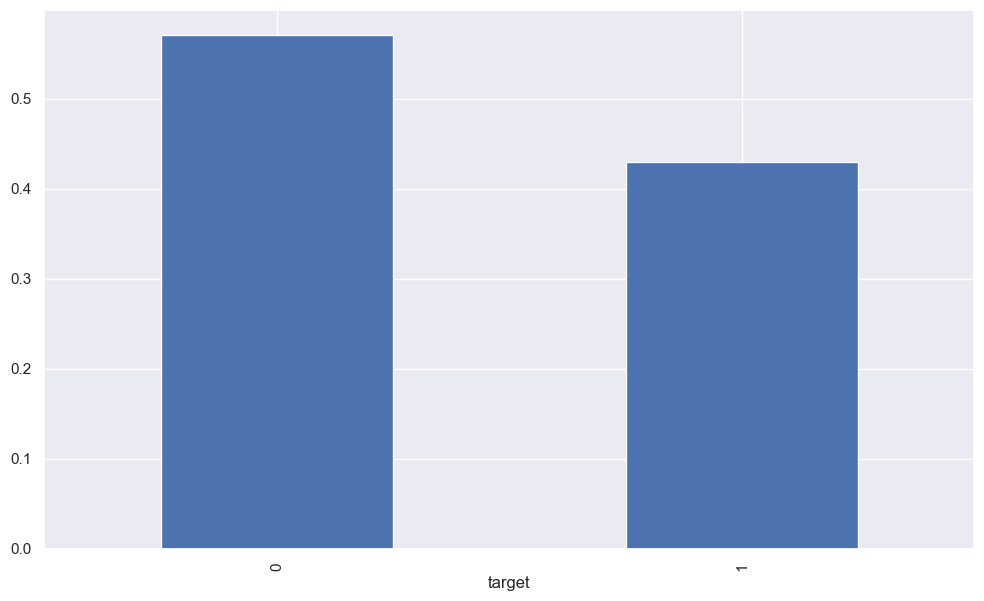

In [573]:
#your code here
data['target'].value_counts(normalize = True).plot(kind = 'bar')
# видим, что распределение классов достаточно равномерное, доли обоих классов близки к 50 процентам 

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

<Axes: xlabel='keyword', ylabel='Count'>

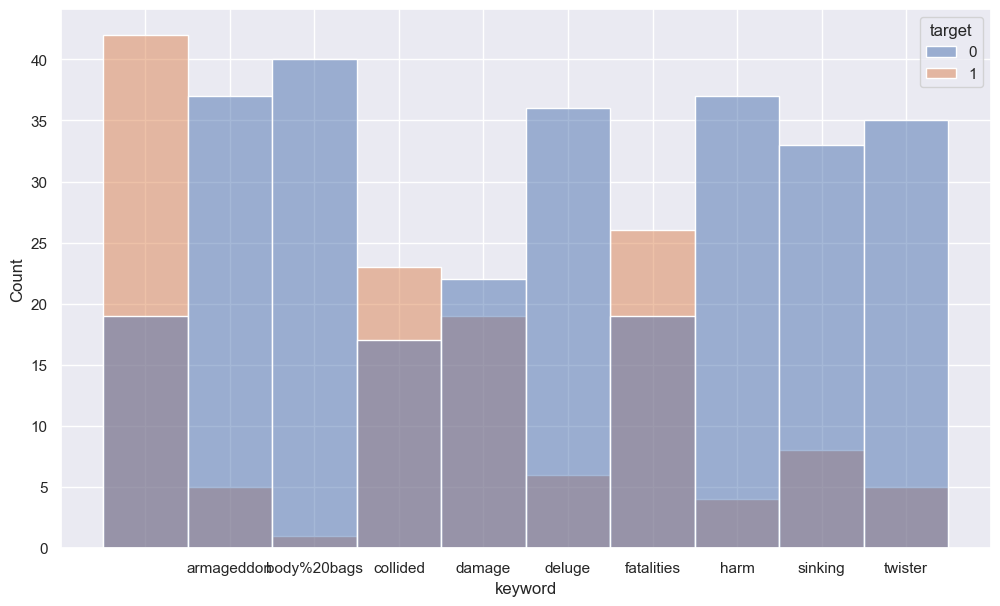

In [574]:
popular_keywords = data['keyword'].value_counts().sort_values(ascending=False)[:10].index.tolist()

import seaborn as sns 
sns.set_theme(rc={'figure.figsize':(12, 7)})
sns.histplot(x = 'keyword', data = data[data['keyword'].isin(popular_keywords)], hue = 'target')

# видим, что по ключевому слову данные редко однозначно разделяются - высокая степень неопределенности у colided, damage, fatalities  - почти совпадает количество наблюдений 0 и 1 классов 

**Ответ:** 
1. распределение классов достаточно равномерное, доли обоих классов близки к 50 процентам 
2. видим, что по ключевому слову данные редко однозначно разделяются - высокая степень неопределенности у colided, damage, fatalities  - почти совпадает количество наблюдений 0 и 1 классов 

#### __Задание 2.3  Подготовка__ (1 балл)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [575]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,NaN,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [576]:
#your code here
train_new = train.drop('id', axis = 1) 
train_new['text'] = train_new['keyword'].astype(str) + train_new['location'].astype(str) + train_new['text'].astype(str)
train_new = train_new.drop(['keyword', 'location'], axis = 1)

In [577]:
test_new = test.drop('id', axis = 1) 
test_new['text'] = test_new['keyword'].astype(str) + test_new['location'].astype(str) + test_new['text'].astype(str)
test_new = test_new.drop(['keyword', 'location'], axis = 1)

In [578]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivorsMarietta, GAStemming from my #Cubs ta...",1
7122,violent%20stormnanIf you were the NWS wth a ro...,1
2769,devastationAtlanta g.a.http://t.co/Gxgm1T3W0J ...,0


In [579]:
test_new.head()

,text,target
2644,destructionnanSo you have a new weapon that ca...,1
2227,delugenanThe f$&amp;@ing things I do for #GISH...,0
5448,policeUKDT @georgegalloway: RT @Galloway4Mayor...,1
132,aftershocknanAftershock back to school kick of...,0
6845,"traumaMontgomery County, MDin response to trau...",0


Далее мы будем пока работать только с train частью. Предобработайте данные (train часть) с помощью CountVectorizer. Какого размера получилась матрица?

In [580]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_new['text'])
X_train.shape


(5329, 22944)

In [581]:
vectorizer.vocabulary_

{'bridge': 4126,
 '20collapsenanashes': 513,
 '2015': 297,
 'australia': 2965,
 'ûªs': 22913,
 'collapse': 5277,
 'at': 2840,
 'trent': 20500,
 'among': 2364,
 'worst': 22173,
 'in': 11172,
 'history': 10581,
 'england': 7949,
 'bundled': 4257,
 'out': 15245,
 'for': 9183,
 '60': 1415,
 'http': 10805,
 'co': 5222,
 't5trhjuau0': 19563,
 'hailcarol': 10091,
 'stream': 19174,
 'illinoisgreat': 11100,
 'michigan': 13629,
 'technique': 19709,
 'camp': 4511,
 'b1g': 3097,
 'thanks': 19884,
 'to': 20195,
 'bmurph1019': 3884,
 'hail_youtsey': 10085,
 'termn8r13': 19769,
 'goblue': 9773,
 'wrestleon': 22315,
 'oaskgki6qj': 14816,
 'policehouston': 15964,
 'cnn': 5215,
 'tennessee': 19751,
 'movie': 13995,
 'theater': 19895,
 'shooting': 18243,
 'suspect': 19465,
 'killed': 12191,
 'by': 4360,
 'police': 15959,
 'di8elzswnr': 6946,
 'riotingnanstill': 17277,
 'rioting': 17262,
 'couple': 5691,
 'of': 14928,
 'hours': 10761,
 'left': 12627,
 'until': 21031,
 'have': 10262,
 'be': 3341,
 'up': 21

#### __Задание 2.4  Работа со словарем__ (1 балл)


В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [582]:
def contains_digit(s: str) -> bool:
    #Проверка, содержит ли слово цифры
    return any(c.isdigit() for c in s) # источник https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number

def contains_punctuation(s: str) -> bool:
    #Проверка, содержит ли слово пунктуацию
    import string
    return any(c in string.punctuation for c in s) # спасибо за стринг https://www.geeksforgeeks.org/string-punctuation-in-python/
    
def is_hashtag(s: str) -> bool:
    #Проверка, является ли слово хэштегом
    if s.startswith('#'):
        return True
    else:
        return False

def is_mention(s: str) -> bool:
    #Проверка, является ли слово упоминанием
    if s.startswith('@'):
        return True 
    else:
        return False

def investigate_vocabulary(vocabulary):
    #your code here
    print('With digit:      ', sum([contains_digit(i) for i in vocabulary.keys()])
          )
    print('With punctuation:', sum([contains_punctuation(i) for i in vocabulary.keys()])
          )
    print('Hashtags:        ', sum([is_hashtag(i) for i in vocabulary.keys()])
          )
    print('Mentions:        ', sum([is_mention(i) for i in vocabulary.keys()])
          )

In [583]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [584]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       4605
With punctuation: 317
Hashtags:         0
Mentions:         0


#### __Задание 2.5  Токенизация__ (0.5 балла)

По умолчанию CountVectorizer определяет токен (слово) как последовательность 2 и более цифр или букв. Пунктуационные символы воспринимаются как разделитель токенов. Такой подход может быть не очень полезен при анализе твитов.

Существуют токенайзеры - модели, которые разбивают тексты на токены (слова), они разные в зависимости от задачи (какие токены могут быть полезны в данной задаче?). Например, в nltk есть токенизатор для твитов - TweetTokenizer.

Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [585]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer
vectorizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
vectorizer.fit(train_new['text'])


/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x31a341850>>)

In [586]:
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       4621
With punctuation: 7574
Hashtags:         1474
Mentions:         1678


**Сравнение:**  так как теперь знаки пунктуации, решетки и собачки не считаются разделителями, то их количество выросло 

#### __Задание 2.6  Кастомный токенайзер__ (2 балла)


В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer


In [587]:
from string import punctuation
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
tweet_tokenizer = TweetTokenizer()
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dmlast/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [588]:
def contains_only_latin_letters(s: str) -> bool:
    #Проверка, содержит ли слово только латинские буквы
    return s.isalpha()

def is_emoji(s: str) -> bool:
    #Проверка, является ли слово смайликом
    return all(char in punctuation for char in s) and any(char in "()" for char in s)


def is_hashtag(s: str) -> bool:
    #Проверка, является ли слово хэштегом
    return s.startswith("#") and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:
    #Кастомный токенайзер
    tokens = tweet_tokenizer.tokenize(s.lower())
    filtered_tokens = []
    
    for token in tokens:
        # Удаление токенов, не соответствующих критериям
        if (contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token)) and token not in set(nltk.corpus.stopwords.words('english')):
            filtered_tokens.append(stemmer.stem(token))  # Применение стемминга
    
    return filtered_tokens




In [589]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [590]:
vectorizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
vectorizer.fit(train_new['text'][:9])
investigate_vocabulary(vectorizer.vocabulary_)

With digit:       11
With punctuation: 25
Hashtags:         3
Mentions:         4


#### __Задание 2.7  Обучаем модель__ (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.

2. Обучите LogisticRegression на полученных признаках.

3. Посчитайте метрику f1-score на тестовых данных.

In [591]:
from sklearn.metrics import f1_score
vectorizer = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
X_train = vectorizer.fit_transform(train_new['text'])
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train, train_new['target'])
f1_score(lr.predict(vectorizer.transform(test_new['text'])), test_new['target'])

0.7381738173817382

#### __Задание 2.8  Другой векторайзер и df__ (1 балл)

Повторите задание 2.7, но с tf-idf векторайзером. Как изменилось качество?

In [592]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=TweetTokenizer().tokenize)
X_train = vectorizer.fit_transform(train_new['text'])
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train, train_new['target'])
f1_score(lr.predict(vectorizer.transform(test_new['text'])), test_new['target'])

/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7377777777777778

In [593]:
X_train.shape

(5329, 24089)

**Ответ:** качество модели незначительно ухудшилось 

В векторайзерах есть параметры min_df и max_df - которые отвечают за ограничния минимальной и максимальной частоте встречаемости токена. Например, если min_df = 3, то мы не учитываем токены, которые встретились менее 3 раз в наших текстах.

Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?

In [594]:
vectorizer = TfidfVectorizer(tokenizer=TweetTokenizer().tokenize, max_df=0.9)
X_train = vectorizer.fit_transform(train_new['text'])
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train, train_new['target'])
f1_score(lr.predict(vectorizer.transform(test_new['text'])), test_new['target'])

/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7377777777777778

In [595]:
X_train.shape

(5329, 24089)

**Ответ:** размер матрицы никак не изменился, как и метрики качества. Я не сразу понял, в чем дело, и полез в документацию, [которая сказала следующее](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer):
```
max_df : float or int, default=1.0
When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float in range [0.0, 1.0], the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.
```
Очевидным образом, у нас нет слов, которые встречаются в 90 процентов твитов. Я перебирал руками некоторые значения, и изменения в качестве удалось получить только при `max_df = 0.1`:

In [596]:
vectorizer = TfidfVectorizer(tokenizer=TweetTokenizer().tokenize, max_df=0.1)
X_train = vectorizer.fit_transform(train_new['text'])
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train, train_new['target'])
f1_score(lr.predict(vectorizer.transform(test_new['text'])), test_new['target'])

/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7338709677419354

In [597]:
X_train.shape

(5329, 24072)

Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

In [598]:
vectorizer = TfidfVectorizer(tokenizer=TweetTokenizer().tokenize, min_df = 3, max_df=0.1)
X_train = vectorizer.fit_transform(train_new['text'])
lr = LogisticRegression(max_iter = 1000000)
lr.fit(X_train, train_new['target'])
f1_score(lr.predict(vectorizer.transform(test_new['text'])), test_new['target'])

/Users/dmlast/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7332576617480137

**Ответ:** я перебрал руками несколько параметров min_df, и при max_df удалось получить только ухудшение качества :-(